In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm  # Use 'import pymc3 as pm' if you have an older version
import arviz as az


In [ ]:
sns.set(style="whitegrid")
%matplotlib inline

# Data loading

In [9]:
df = pd.read_csv('date_promovare_examen.csv')

X = df[['Ore_Studiu', 'Ore_Somn']].values
y = df['Promovare'].values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X-X_mean)/X_std

print("Data Loaded and Scaled.")
print(f"Features Mean: {X_mean}")
print(f"Features Std: {X_std}")

Data Loaded and Scaled.
Features Mean: [4.00678 6.51576]
Features Std: [2.21901866 1.5298251 ]


# Our Bayesian Logistic Regression Model

In [10]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=10, shape=2)

    mu = alpha + pm.math.dot(X_scaled, betas)

    theta = pm.math.sigmoid(mu)

    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y)

    trace = pm.sample(draws=1000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 2947 divergences after tuning. Increase `target_accept` or reparameterize.


# Trace plots

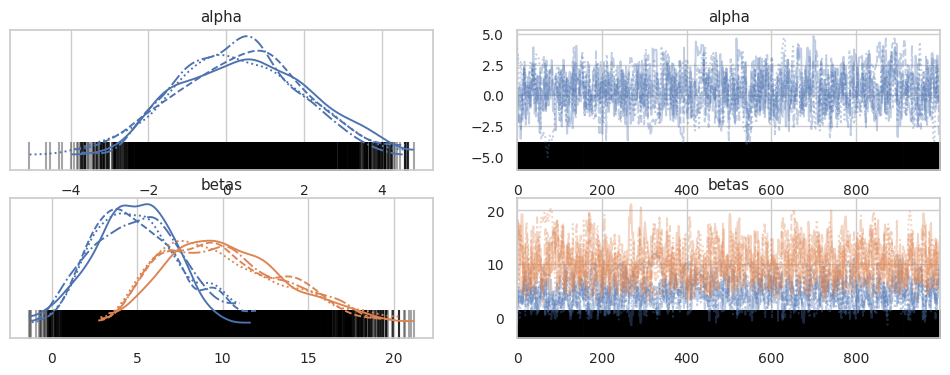

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha      0.364  1.642  -2.504    3.483      0.071    0.050     520.0   
betas[0]   4.962  2.464   0.565    9.668      0.117    0.073     444.0   
betas[1]  10.197  3.588   4.349   16.969      0.164    0.099     504.0   

          ess_tail  r_hat  
alpha        475.0   1.01  
betas[0]     360.0   1.00  
betas[1]     535.0   1.00  


In [11]:
az.plot_trace(trace, var_names=['alpha', 'betas'])
plt.show()

summary = az.summary(trace, var_names=['alpha', 'betas'])
print(summary)

# Decision Boundary Visualization

In [12]:
# Extract the mean of the posterior for alpha and betas
alpha_mean = trace.posterior['alpha'].mean().item()
betas_mean = trace.posterior['betas'].mean(dim=["chain", "draw"]).values

# Calculate the decision boundary line in the SCALED space
# Equation: alpha + beta1*x1 + beta2*x2 = 0  => x2 = -(alpha + beta1*x1) / beta2
x_scaled_range = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 100)
y_scaled_boundary = -(alpha_mean + betas_mean[0] * x_scaled_range) / betas_mean[1]

# Unscale the values back to original units (Hours) for plotting
x_original = x_scaled_range * X_std[0] + X_mean[0]
y_original = y_scaled_boundary * X_std[1] + X_mean[1]

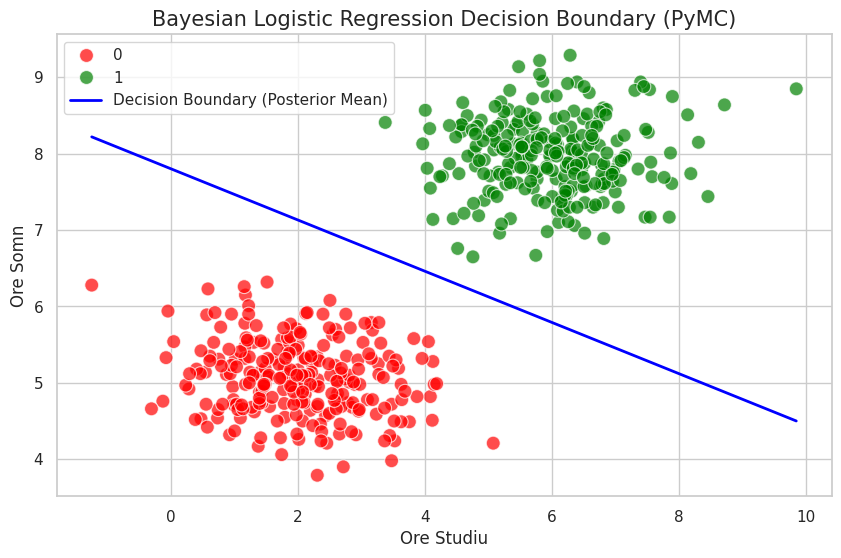

In [13]:
plt.figure(figsize=(10, 6))

# 1. Scatter plot of data
sns.scatterplot(
    x=df['Ore_Studiu'],
    y=df['Ore_Somn'],
    hue=df['Promovare'],
    palette={0: 'red', 1: 'green'},
    s=100,
    alpha=0.7
)

# 2. Decision Boundary
plt.plot(x_original, y_original, label='Decision Boundary (Posterior Mean)', color='blue', lw=2)

plt.title('Bayesian Logistic Regression Decision Boundary (PyMC)', fontsize=15)
plt.xlabel('Ore Studiu')
plt.ylabel('Ore Somn')
plt.legend()
plt.show()